In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [2]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils

# Get K2 data

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([], dtype=int64))
Using *GP* to flatten (can be 'GP', 'Median', or default to SavGol)
there can still be leftover bad points, so sigma clipping is recommended
Also might be good to rerun with transitmask set
WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically masked.


/Users/gks/anaconda/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/gks/anaconda/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


3386
3330
Using period range [ 1. 50.]
Overwriting: df= [9.8e-05] fmin= 0.02 freq_range [0.02 1.  ]
Computing bls...
=====Results====
Best period: 2.26050002261
Best freq: 0.44238
Depth: 0.00431379865714
Epoch: 2144.9920223184486
Number of transits: 30
Optimization terminated successfully.
('Per=', 2.2604373106175024, 'epoch=', 2144.9902420830567)


../src/k2help.py:232: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"pl_hostname","EPIC "+str(self.s.id))
../src/k2help.py:233: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"pl_name","EPIC "+str(self.s.id))
../src/k2help.py:235: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"ra_str",utils.radecDeg2hourangleHMS(self.s.k2_ra,self.s.k2_dec,sep_doubledots=False)[0])
../src/k2help.py:237: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"dec_str",utils.radecDeg2hourangleHMS(self.s.k2_ra,self.s.k2_dec,sep_doubledots=False)[1])
../src/k2help.py:238: FutureWarning: set_value is deprecated and will be re

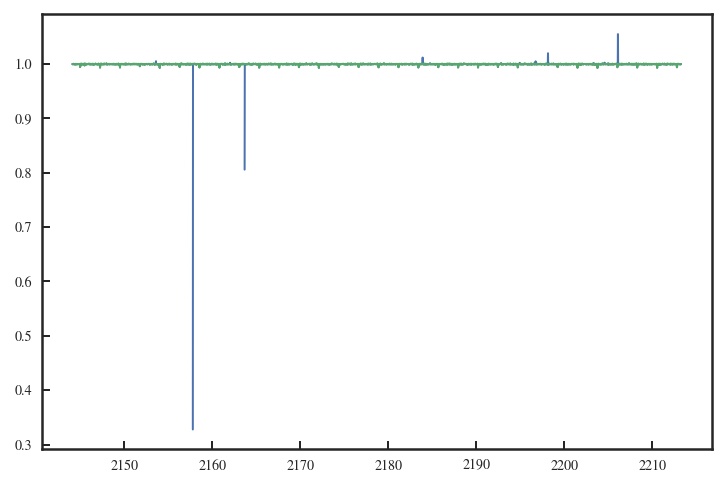

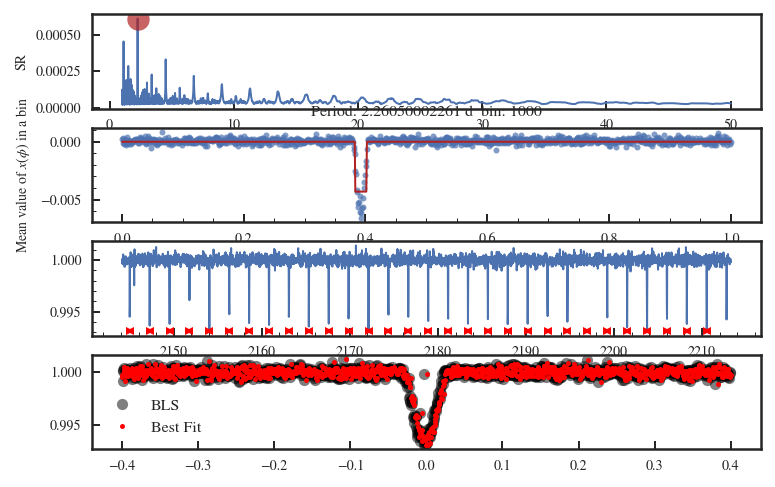

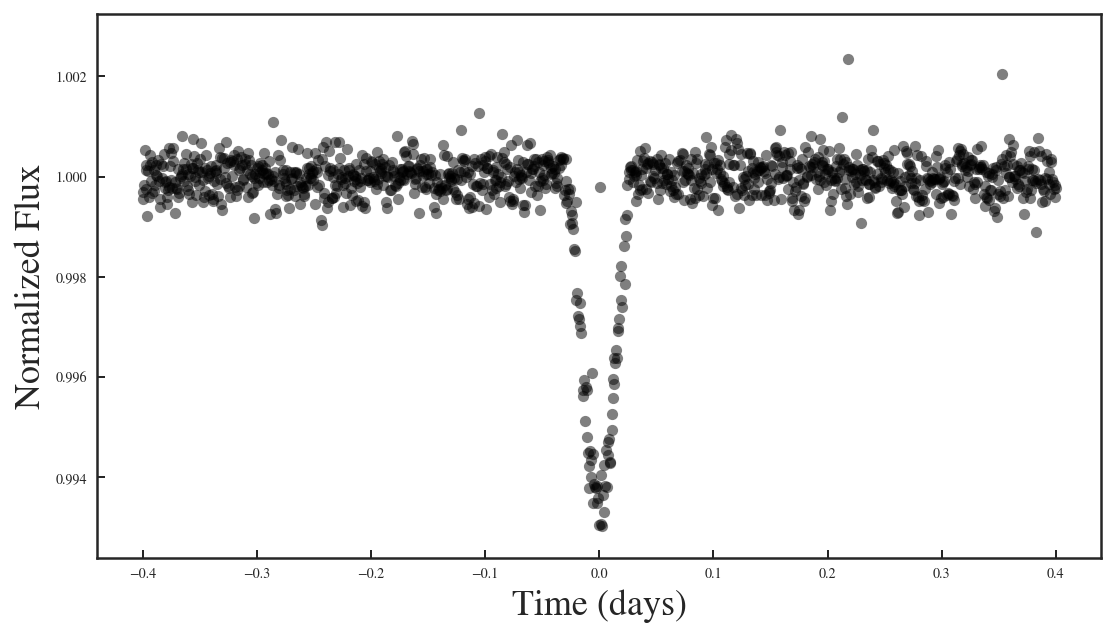

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 2584, 2585,
       2586, 2587, 2588, 2589, 2590, 2591, 2592,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48, 1588, 1589, 1590, 1591, 1592,
       1593, 1594, 1595, 1596, 1597, 3137, 3138, 3139, 3140, 3141, 3142,
       3143, 3144, 3145, 3146,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148,
       2149, 2150, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153,
       1154, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703,
        150,  151,  152,  153,  154,  155,  156,  157,  158, 1699, 1700,
       1701, 1702, 1703, 1704, 1705, 1706, 1707, 3247, 3248, 3249, 3250,
       3251, 3252, 3253, 3254, 3255, 3256,  703,  704,  705,  706,  707,
        708,  709,  710,  711,  712, 2252, 2253, 2254, 22

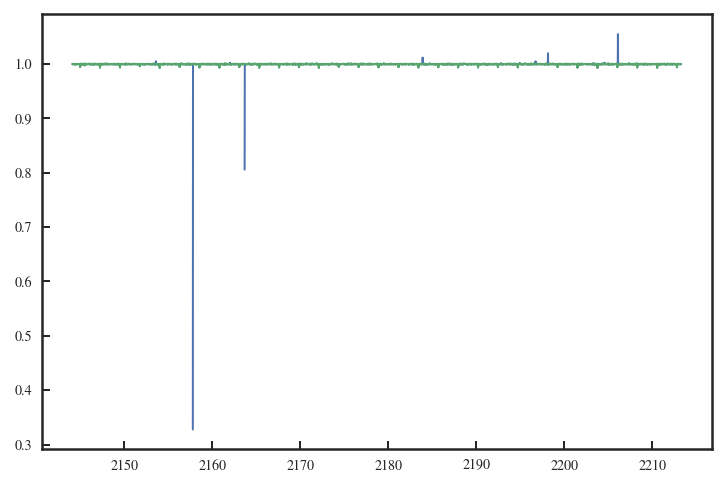

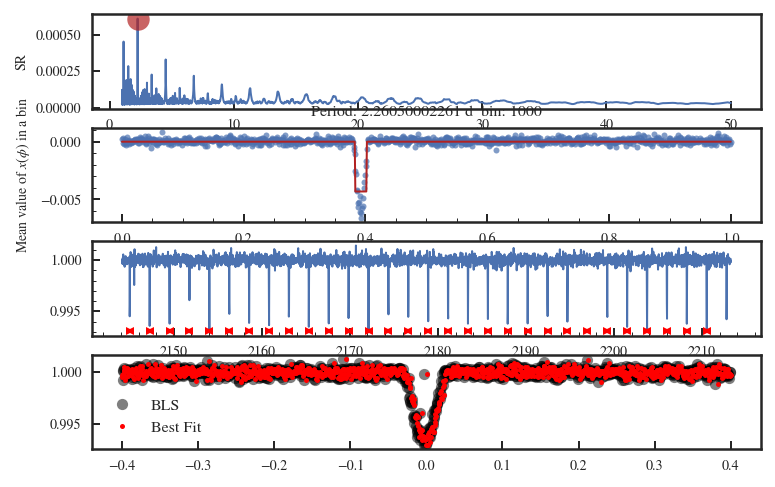

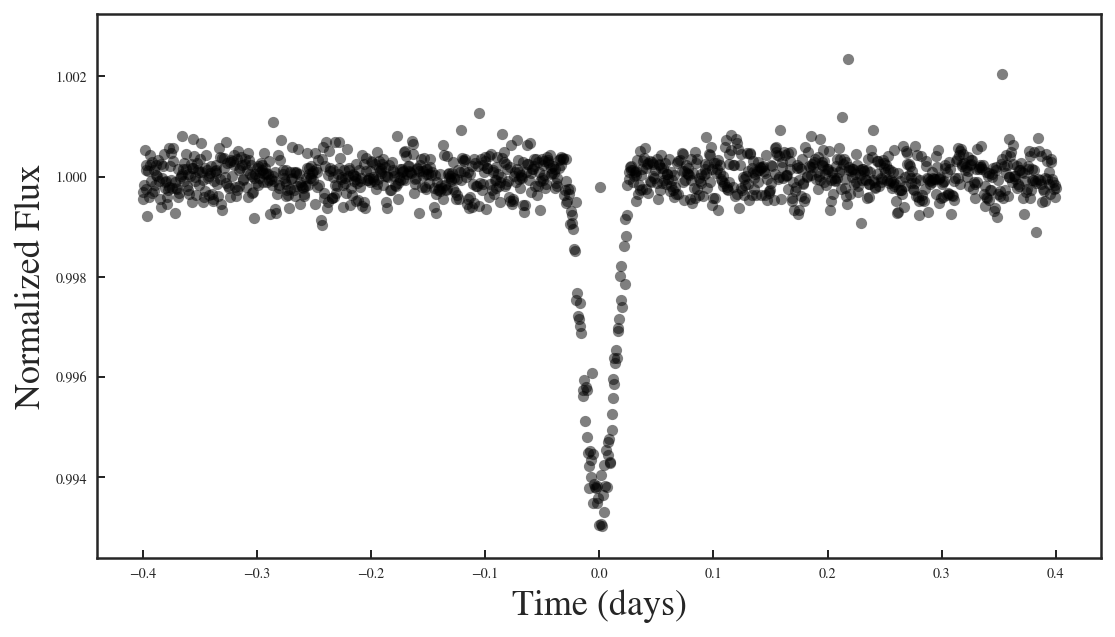

In [3]:
DUR = 0.2
EP = epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP")
planet = EP(dur=DUR)
EP = epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP",transitmask=EP.star.transitmask)
planet = EP(dur=DUR)

('Using planet with t0=', 2144.990239353385, 'and P=', 2.260437208157793)
Using median filtered data -- assumes you have run that from beginning!


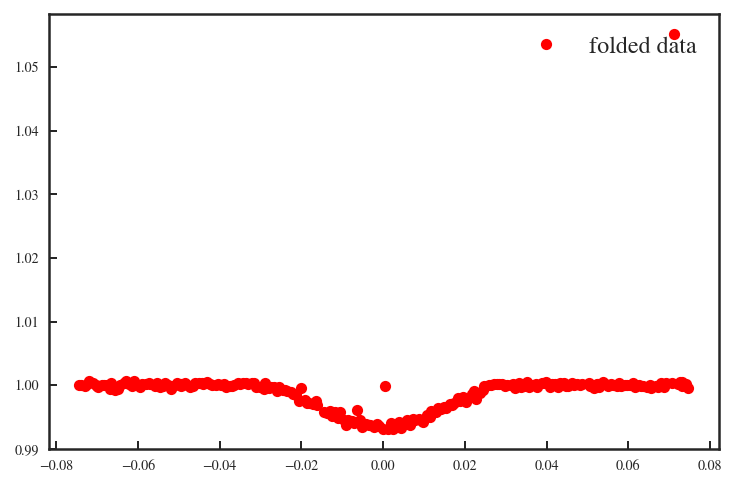

In [4]:
#t_ufold, f_ufold, t_fold, f_fold = EP.cutout_transits(dur=0.4)
df = EP.get_cutout_phased_df(dur=0.15,sigma=None)
df = df.reset_index(drop=True)
df= df.sort_values("x")

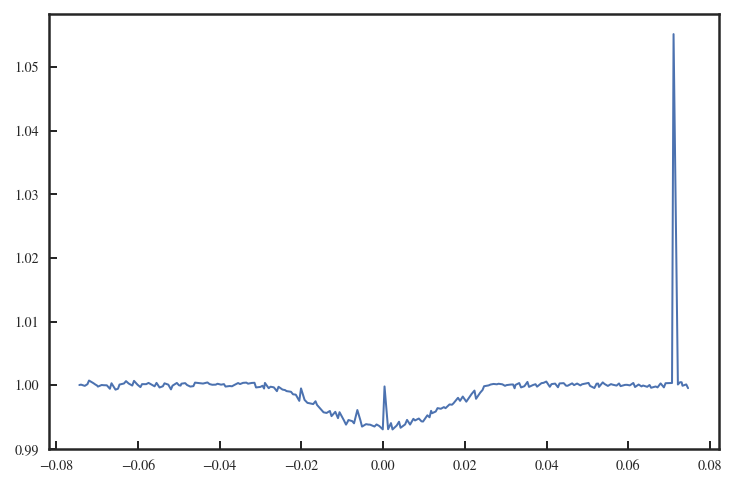

In [5]:
plt.plot(df.x.values,df.y.values)

224
[ 83 103 113 217]
220


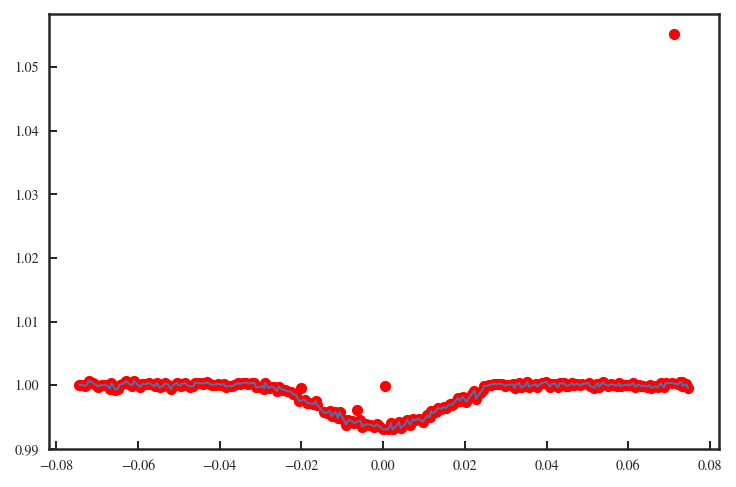

In [6]:
t,f,m,mm = k2help.median_filter_and_sigma_clip(df.x.values,df.y.values,return_mask=True,sigma=3,window=31)
print(len(df))
print(m)
plt.plot(df.x, df.y,"r.")
dfmm= df.drop(m)
t_fold_final = dfmm.x
f_fold_final = dfmm.y
plt.plot(dfmm.x,dfmm.y)
print(len(dfmm))

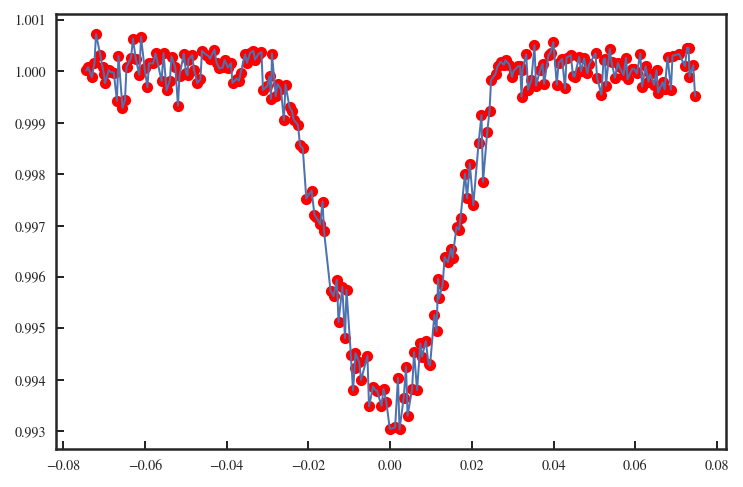

In [7]:
dfmm_s = dfmm.sort_index()
dfmm_s["time"] = dfmm_s.time.values + k2help.KEPLER_JD_OFFSET
plt.plot(dfmm_s.x,dfmm_s.y,"r.")
plt.plot(dfmm.x,dfmm.y)
dfmm_s = dfmm_s.sort_values("time")

# Read Ground Based 

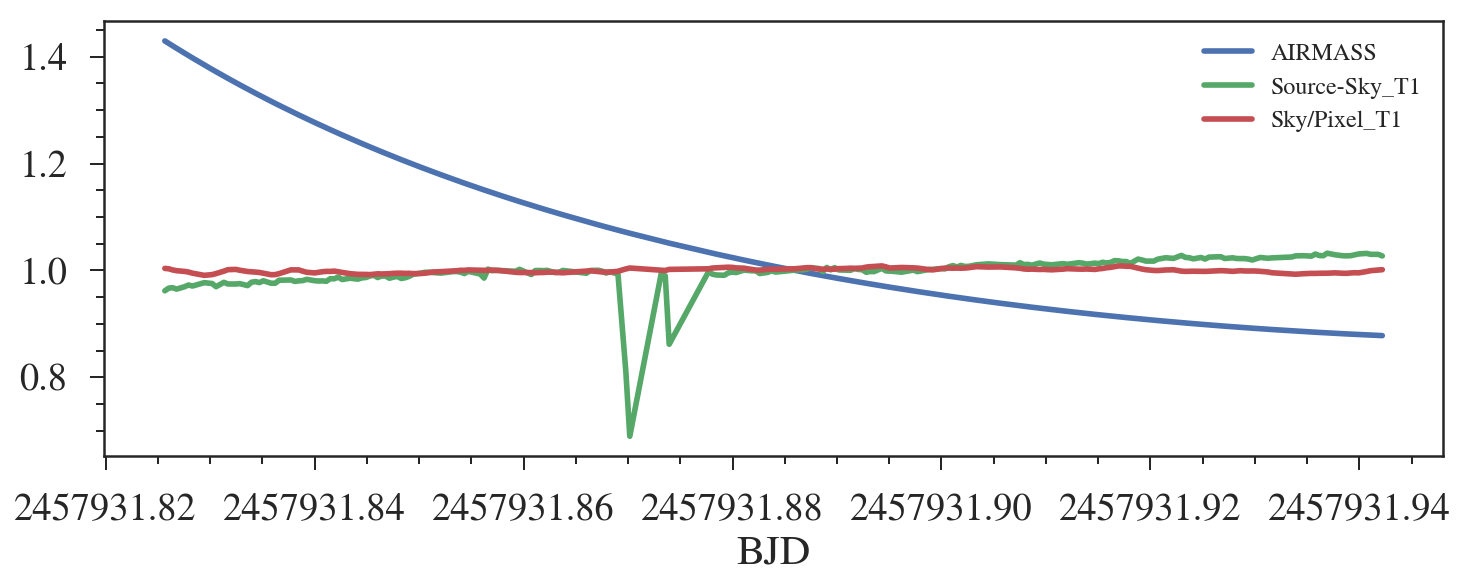

In [10]:
df_ground = pd.read_csv("../data/k2_28b/Processed_K2-28b-diffuserin-30s_measurements.xls",sep="\t")
# Take out bad sky points
df_ground = df_ground[0:-20]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground.AIRMASS))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground["Source-Sky_T1"]))
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Sky/Pixel_T1"])-1)*0.1)+1.)

ax.set_xlabel("BJD")
ax.legend(loc="upper right",fontsize=12)
ax.minorticks_on()

In [11]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 3.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {}".format(final_unbinned_scint_noise))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 32.5728267431s
Mean photon error: 0.000451928909953
Mean scint error: 0.000635806262651


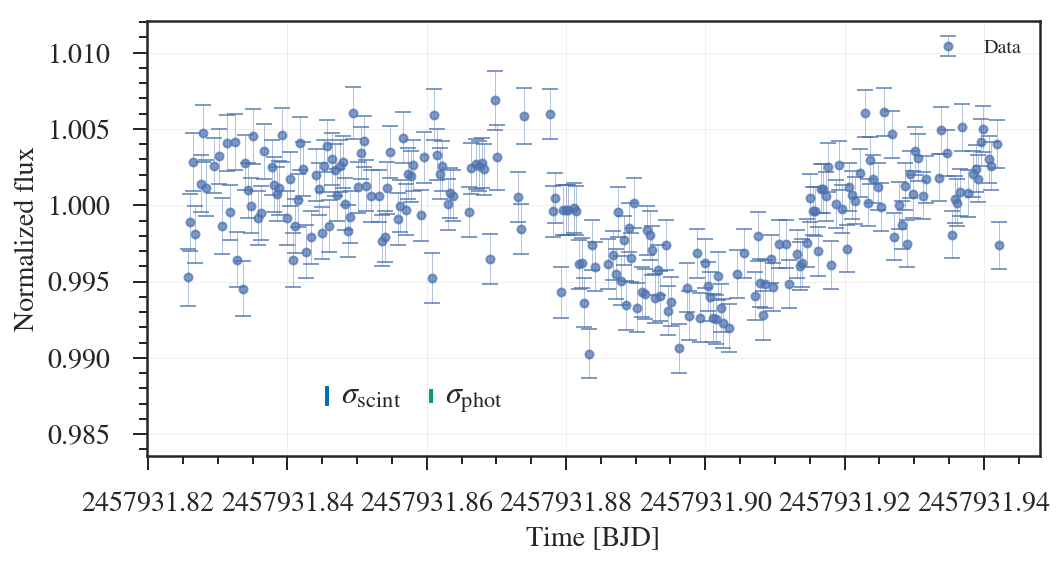

In [14]:
import plot_transits
fig, ax = plt.subplots(figsize=(8,4))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=14)
ax.set_ylabel("Normalized flux",fontsize=14)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=10)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=14)

### Calculate Scintillation errorbars

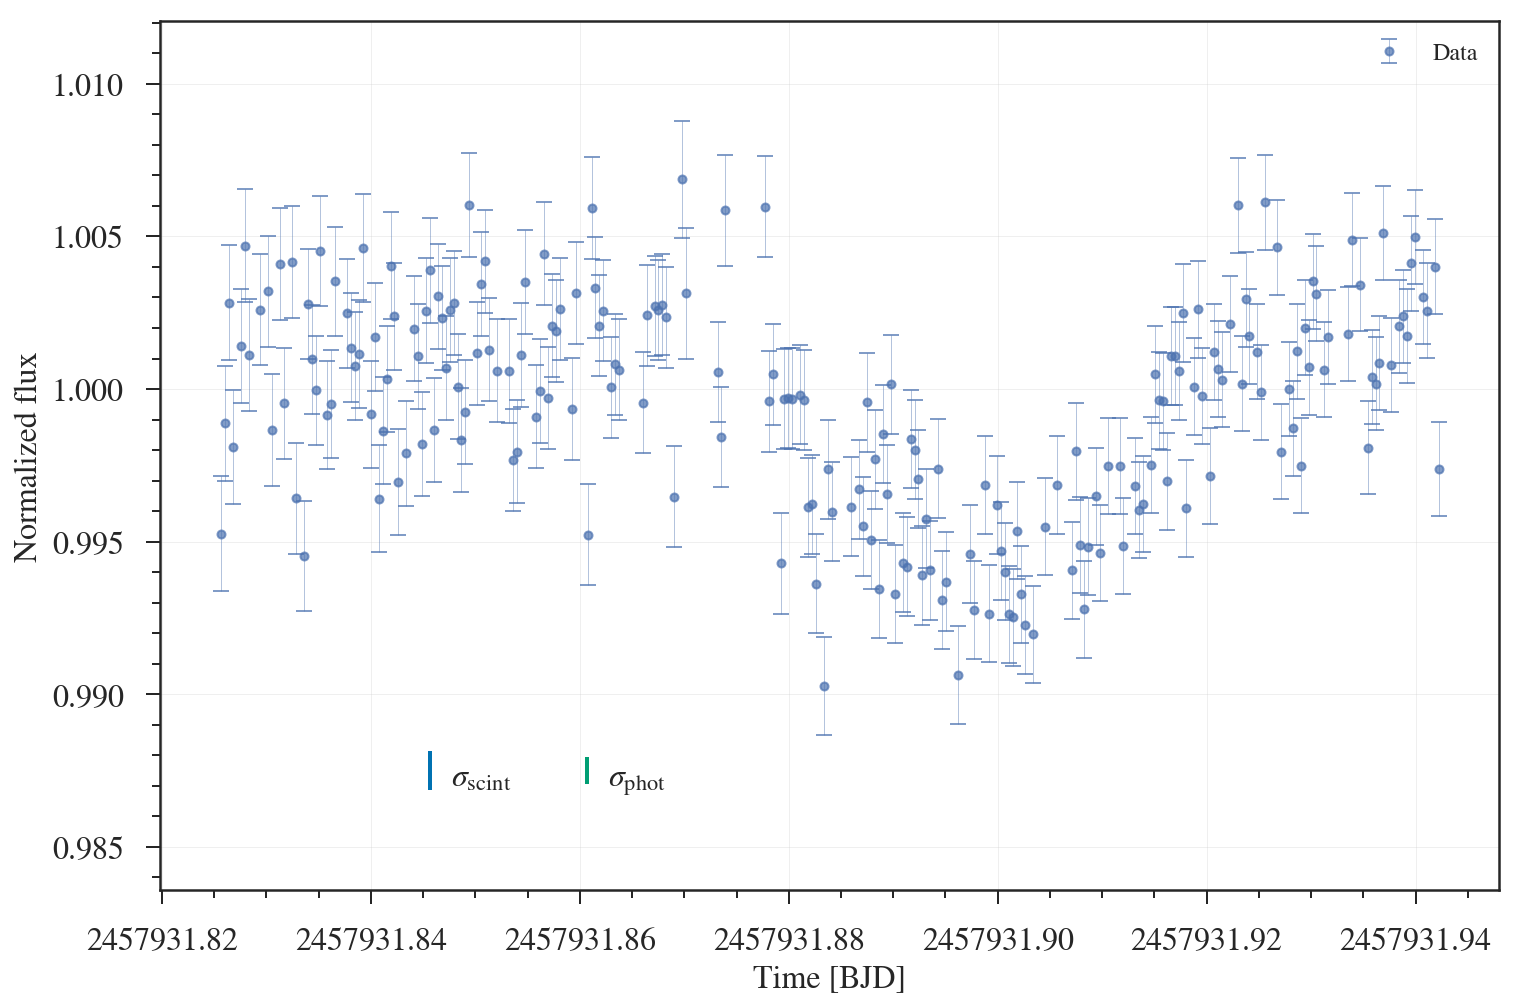

In [13]:
import plot_transits
fig, ax = plt.subplots(figsize=(12,8))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=16)
ax.set_ylabel("Normalized flux",fontsize=16)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=12)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=16)

In [15]:
#import astropylib

ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

_p = np.log10(pp[0])
_t0   = planet.get_attributeAndError("_pl_tranmid")[0]

print("log(P)",mcmc_utils.err_logP_from_p(pp))
print("cos(i)",mcmc_utils.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcmc_utils.err_logaRs_from_aRs(aRs))
print(_p)
print(_t0)

log(P) [0.3541924474334233, nan]
cos(i) [0.005432684798786842, nan]
RpRs (0.07446521431014846, nan)
log(aRs) [1.3168087280927998, nan]
0.3541924474334233
2456977.9902393534


In [16]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data1= {"time"  : dfmm_s.time.values,  # phase folded time in days (centered on 0)
                    "flux"   : dfmm_s.y.values   # phase folded flux
                    }
        self.data2= {"time" : t_ground,
                     "flux" : f_ground,
                     "error": tot_error
                    }
        #####
        
        # Setting priors
        self.priors = [UP( 2457931.90-0.05     , 2457931.90+0.05        , 'tc'       ,r'$T_C$'                ,priortype="model"),  ##   5 - Transit centre, Tc
                       #UP( _t0 -0.001          , _t0+0.001              , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   4 - Transit centre, Tc
                       UP( _p  -0.002          , _p  +0.002             , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   0 - log(P)
                       UP( 0.                  , 0.2                    , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   1 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs_1'   ,r'$R_p/R_s$1'             ,priortype="model"),  ##   6 - rp/rstar
                       UP( 0.9                 , 2.0                    , 'log(a/Rs)',r'$\log(a/R_s)$2'         ,priortype="model"),  ##   2 - log(a/rstar)
                       UP( 0.0                 , 0.1                    , 'RpRs_2'   ,r'$R_p/R_s$2'            ,priortype="model"),  ##   7 - rp/rstar
                       #UP( 0.                  , 1.                     , 'q1_1'     ,r'$q_1$1'                ,priortype="model"),  ##   8 - q1
                       #UP( 0.                  , 1.                     , 'q2_1'     ,r'$q_2$1'                ,priortype="model"),  ##   9 - q2
                       #UP( 0.                  , 1.                     , 'q1_2'     ,r'$q_1$2'                ,priortype="model"),  ##   10 - q1
                       #UP( 0.                  , 1.                     , 'q2_2'     ,r'$q_2$2'                ,priortype="model"),  ##   11 - q2
                       UP( 0.9                 , 1.1                    , 'fraw1'    ,r'fraw1'                 ,priortype="baseline1"),## 12 - Baseline constant
                       UP( 0.9                 , 1.1                    , 'fraw2'    ,r'fraw2'                 ,priortype="baseline2"),
                       UP( 1e-5                , 50e-5                  , 'err1'     ,r'error1'                ,priortype="error1")]## 13 - Baseline constant
        
        self.ps     = PriorSet(self.priors)
        print("Baseline1 is at pv=",self.pv_lab2Idx("fraw1"))
        print("Baseline2 is at pv=",self.pv_lab2Idx("fraw2"))
        print("Error is at pv=",self.pv_lab2Idx("err1"))
        
    def pv_lab2Idx(self,pv_label):
        return np.where(np.array(self.ps.labels)==pv_label)[0][0]
            
    def compute_transit(self,pv,times1=None,times2=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        # First transit, K2
        self.params1 = batman.TransitParams()
        self.params1.t0 = pv[self.pv_lab2Idx("tc")]
        self.params1.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params1.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params1.rp = pv[self.pv_lab2Idx("RpRs_1")]
        self.params1.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params1.ecc = 0.
        self.params1.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_1")], pv[self.pv_lab2Idx("q2_1")]
        #self.params1.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params1.u = [0.4266, 0.3076]
        self.params1.limb_dark = "quadratic"
        self.params1.fp = 0.001
        if times1 is None:
            times1 = self.data1["time"]
        transitmodel = batman.TransitModel(self.params1, times1, transittype='primary',supersample_factor=7,exp_time=0.020431801470066003)
        self.lc1 = transitmodel.light_curve(self.params1)
        
        # Second transit, ground,
        self.params2 = batman.TransitParams()
        self.params2.t0 = pv[self.pv_lab2Idx("tc")]
        self.params2.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params2.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params2.rp = pv[self.pv_lab2Idx("RpRs_2")]
        self.params2.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params2.ecc = 0.
        self.params2.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_2")], pv[self.pv_lab2Idx("q2_2")]
        #self.params2.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params2.u = [0.3402,0.3156]
        self.params2.limb_dark = "quadratic"
        self.params2.fp = 0.001
        if times2 is None:
            times2 = self.data2["time"]
        transitmodel = batman.TransitModel(self.params2, times2, transittype='primary')
        self.lc2 = transitmodel.light_curve(self.params2)
        return self.lc1, self.lc2      
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data2["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            detrend += pv[i]*(self.data2[self.ps.labels[i]]-1.)
        return detrend/pv[self.pv_lab2Idx("fraw2")]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            The full light curve model with a trend
        """
        f1, f2 = self.compute_transit(pv)
        # Return the flux from K2, and then detrended flux from ground
        return f1, f2 + self.detrend(pv)
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        NOTES:
            This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m1, flux_m2 = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        
        scaled_flux1  = self.data1["flux"]/pv[self.pv_lab2Idx("fraw1")]
        scaled_flux2  = self.data2["flux"]/pv[self.pv_lab2Idx("fraw2")]
        
        log_of_model1  = ll_normal_es(scaled_flux1, flux_m1, pv[self.pv_lab2Idx("err1")])
        log_of_model2  = ll_normal_ev(scaled_flux2, flux_m2, self.data2["error"])

        log_ln = log_of_priors + log_of_model1 + log_of_model2
        
        return log_ln

In [17]:
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
import trf
TF = trf.TransitFit(LPFunction)

Baseline1 is at pv= 6
Baseline2 is at pv= 7
Error is at pv= 8


In [33]:
#TF.minimize_PyDE(mcmc=False)

In [34]:
#TF.lpf.ps.plot_all(TF.min_pv)

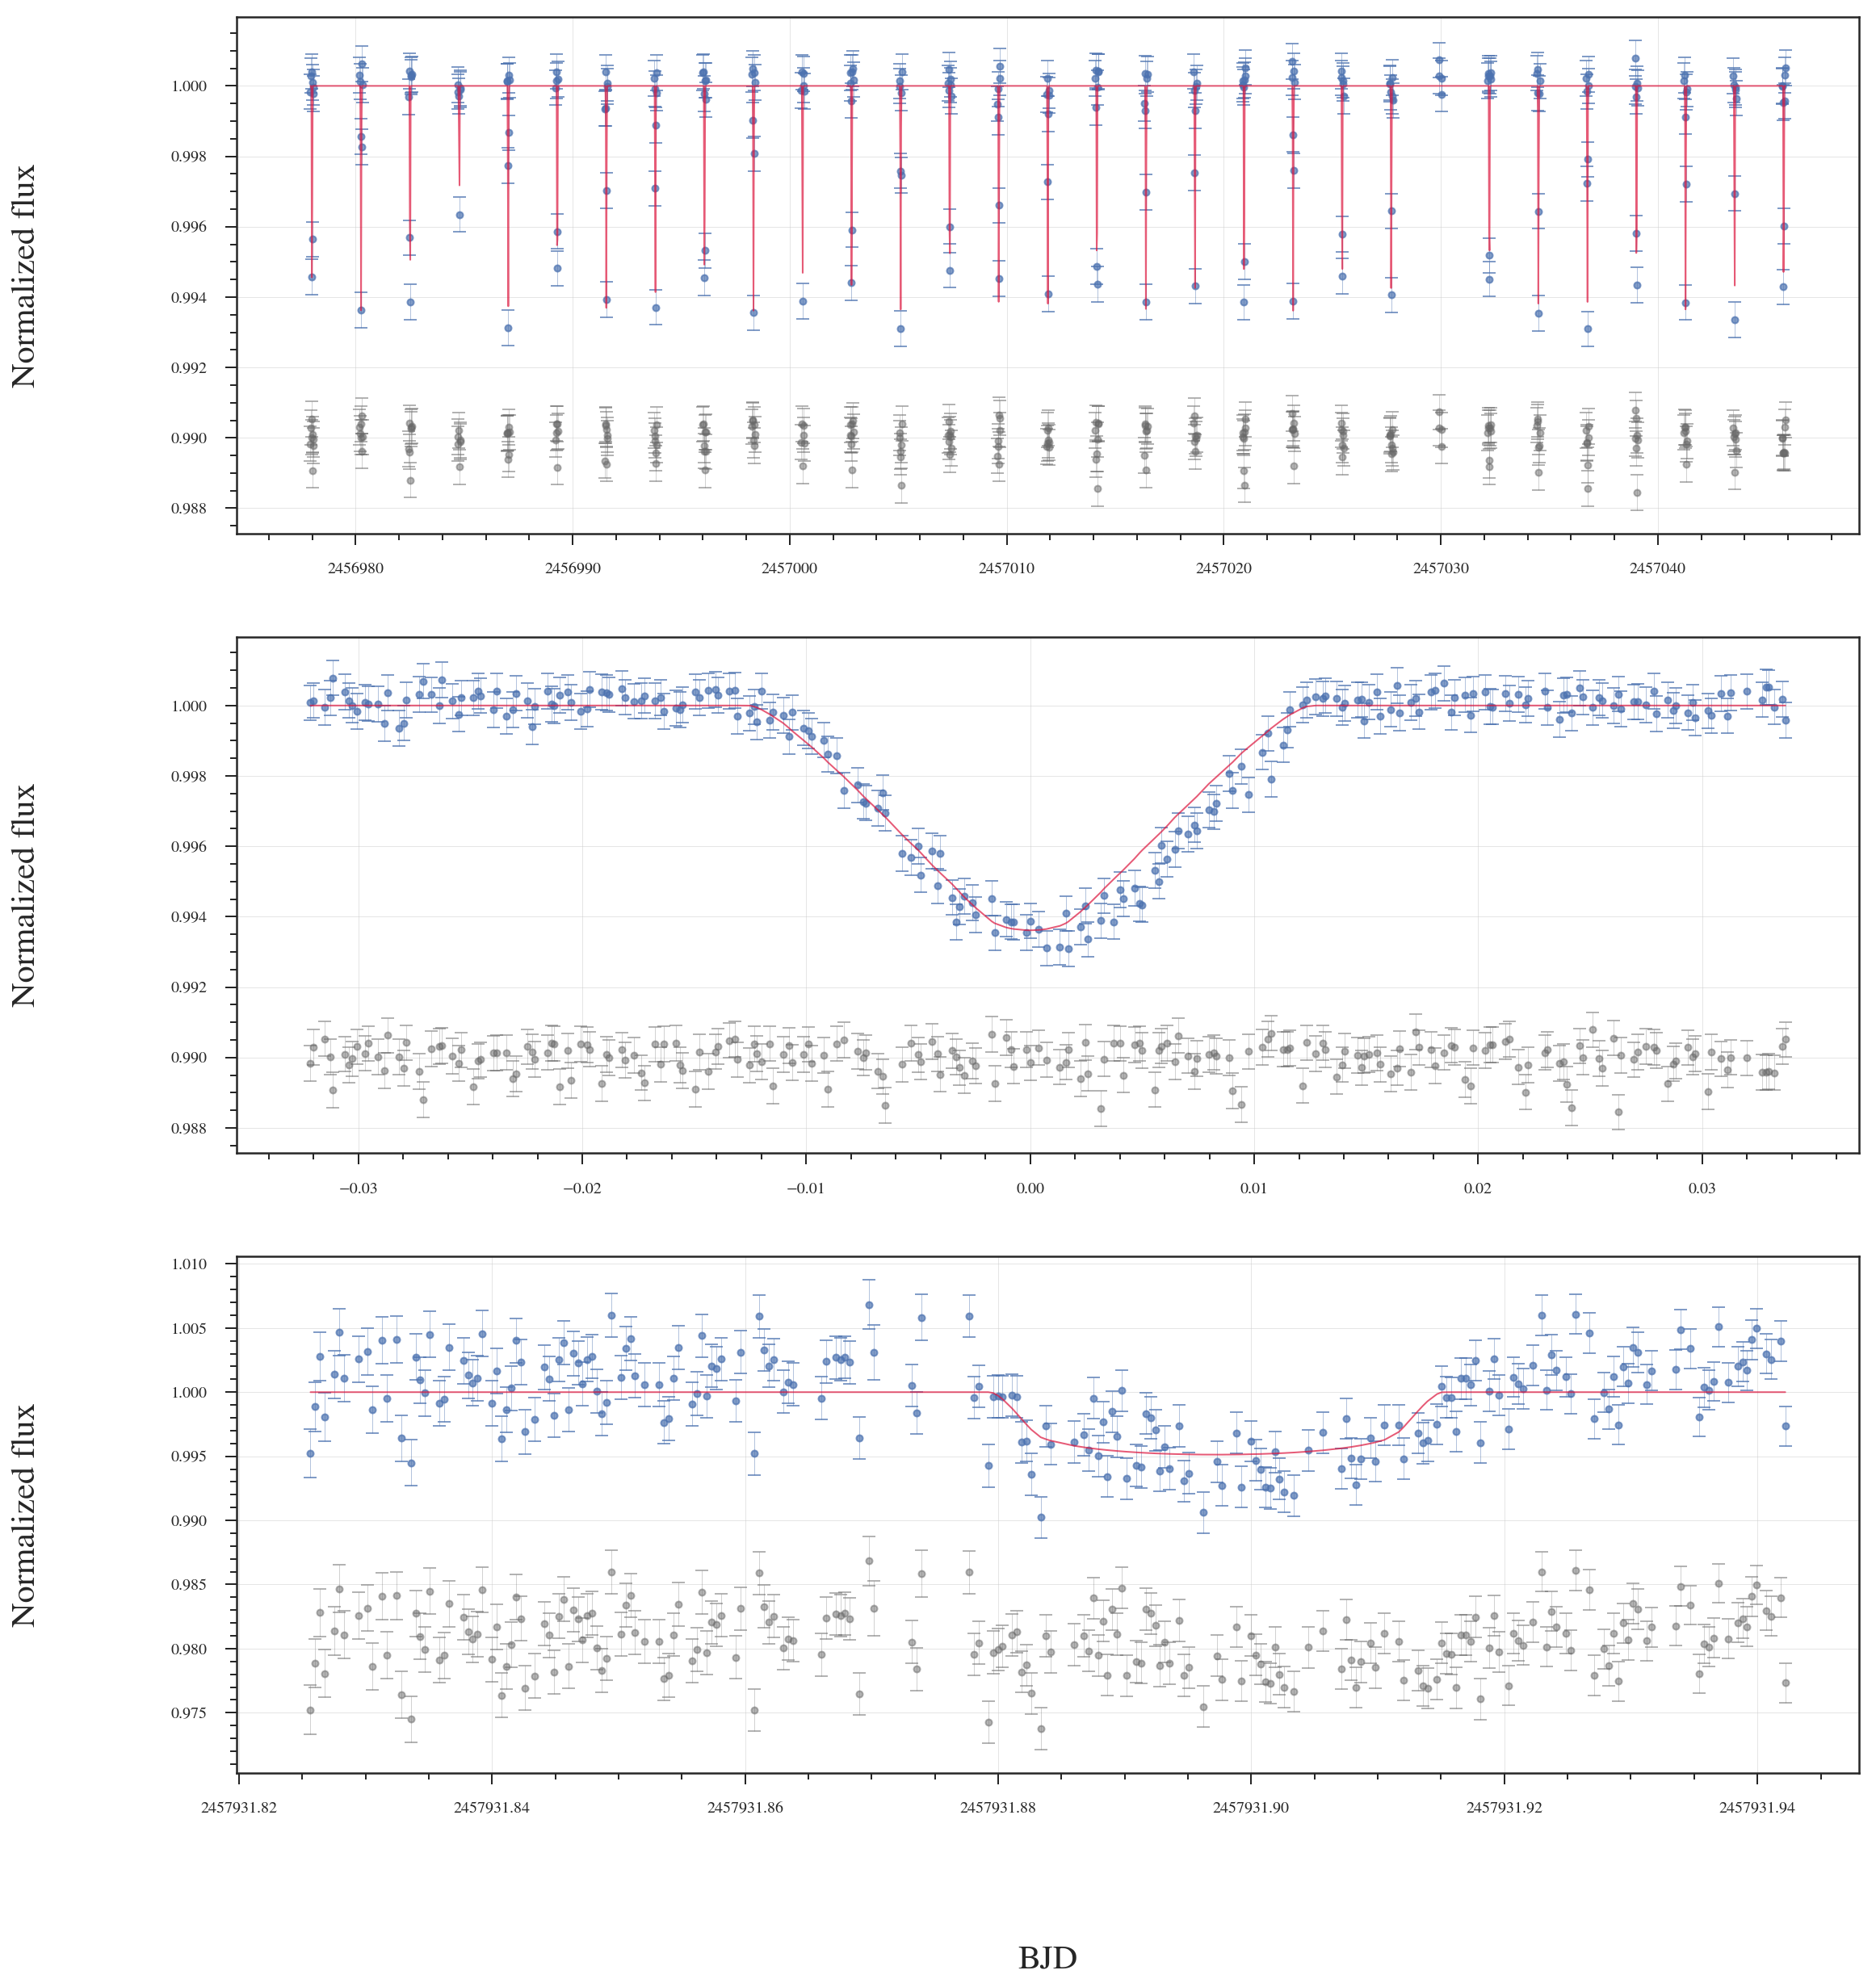

In [33]:
pv = TF.min_pv
t0  = pv[0]
p  = 10.**(pv[1])
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,20))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

In [19]:
TF.minimize_PyDE(mc_iter=4000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06     0.002768
1       logP  3.541924e-01  3.521924e-01  3.561924e-01  3.541944e-01    -0.000002
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  4.044670e-02     0.059553
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  7.938078e-02    -0.029381
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.221998e+00     0.228002
5     RpRs_2  5.000000e-02  0.000000e+00  1.000000e-01  6.765125e-02    -0.017651
6      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  9.999411e-01     0.000059
7      fraw2  1.000000e+00  9.000000e-01  1.100000e+00  1.000029e+00    -0.000029
8       err1  2.550000e-04  1.000000e-05  5.000000e-04  4.992088e-04    -0.000244
LogLn value: -2305.697376917843
Log priors 24.78332492492725
Running MCMC
MCMC iterations= 4000
0 1 2 3 4 5 6 7 8 9 10

Plotting chains


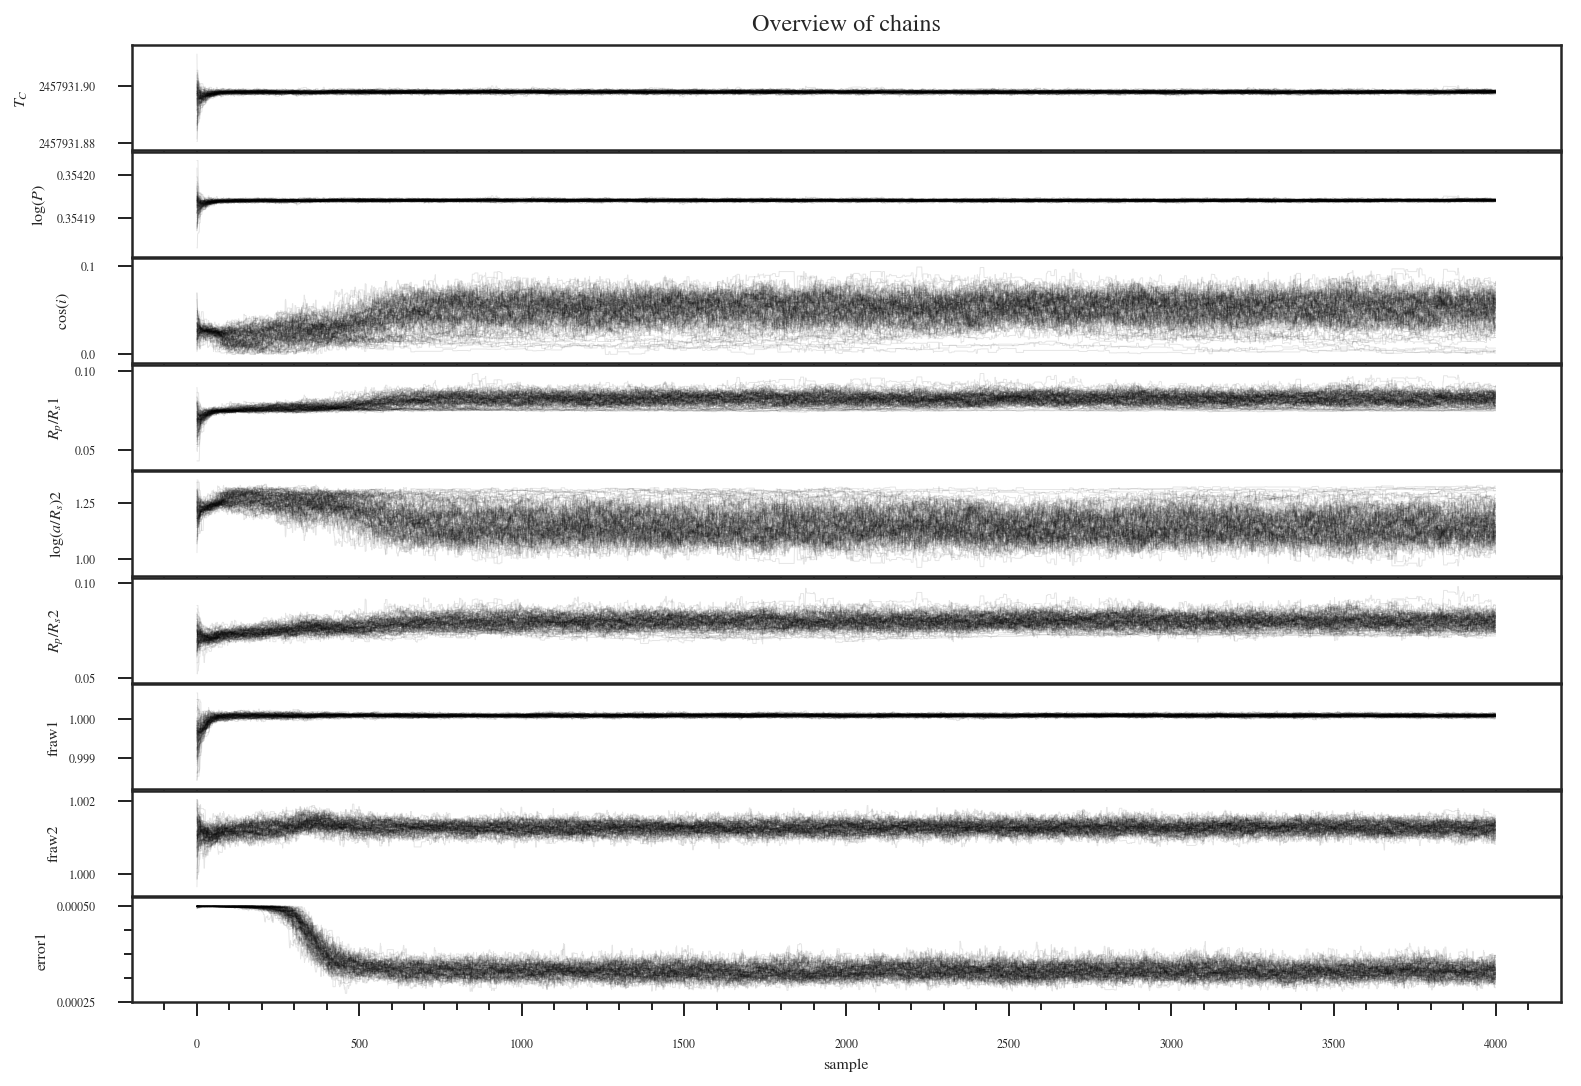

In [20]:
TF.plot_chains(burn=0)

Plotting chains


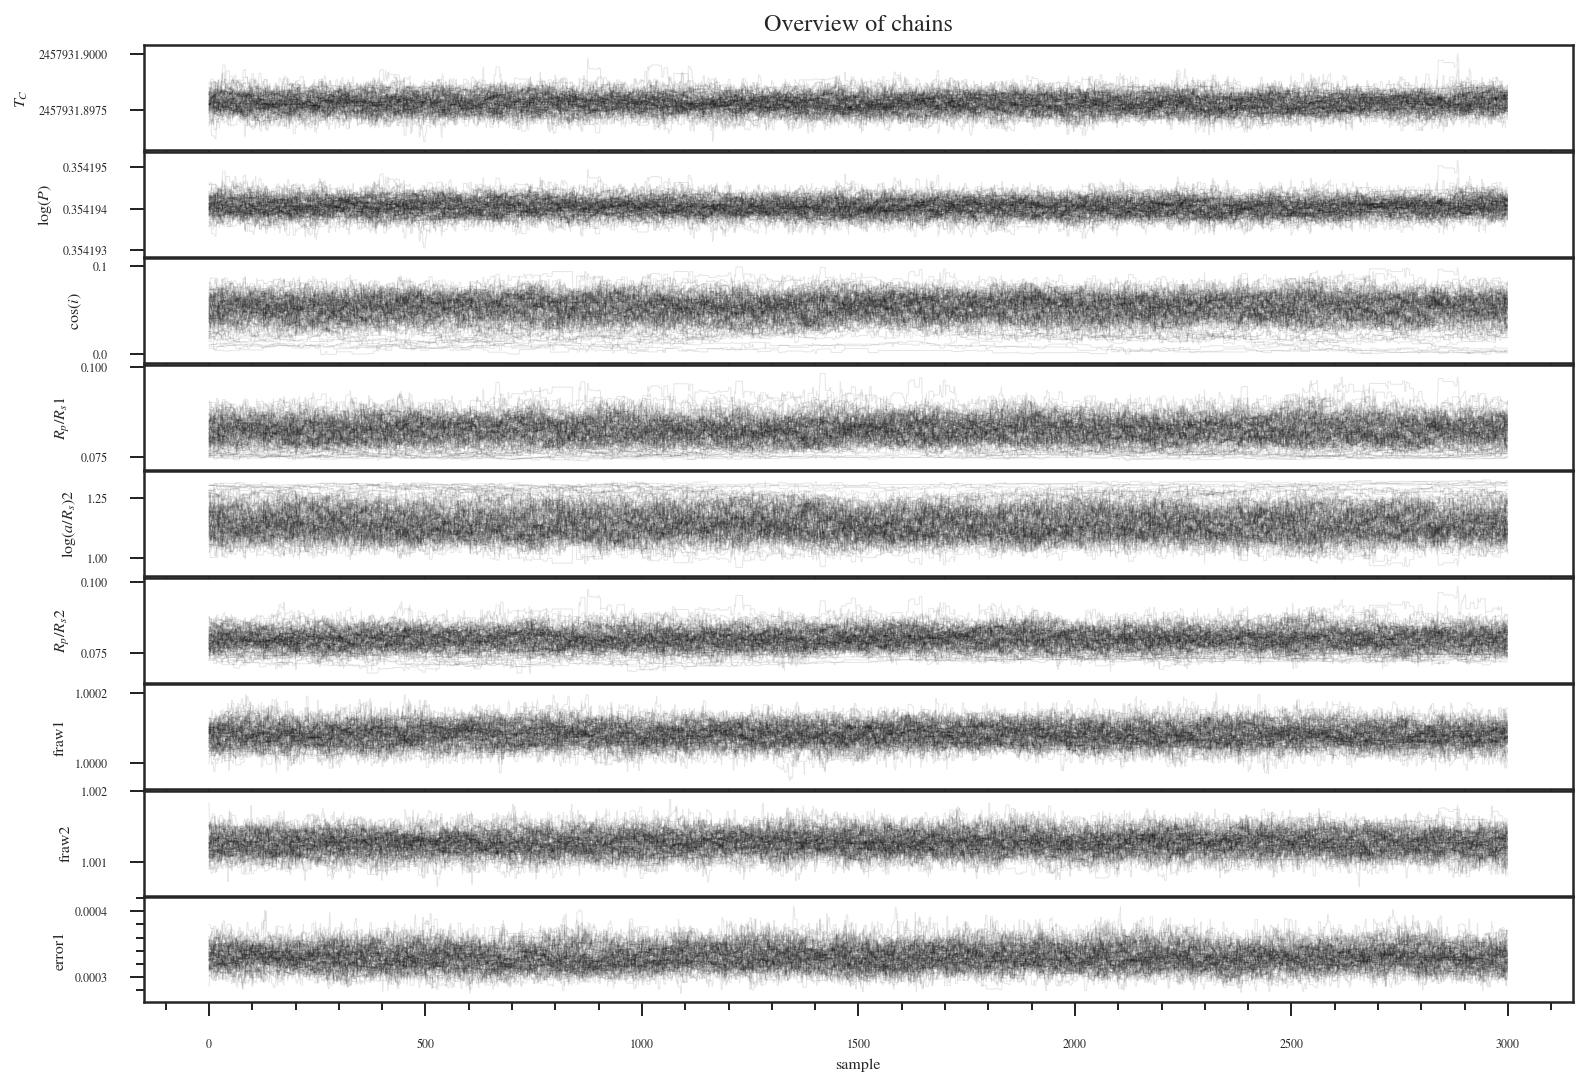

In [21]:
TF.plot_chains(burn=1000)

Plotting cornerplot


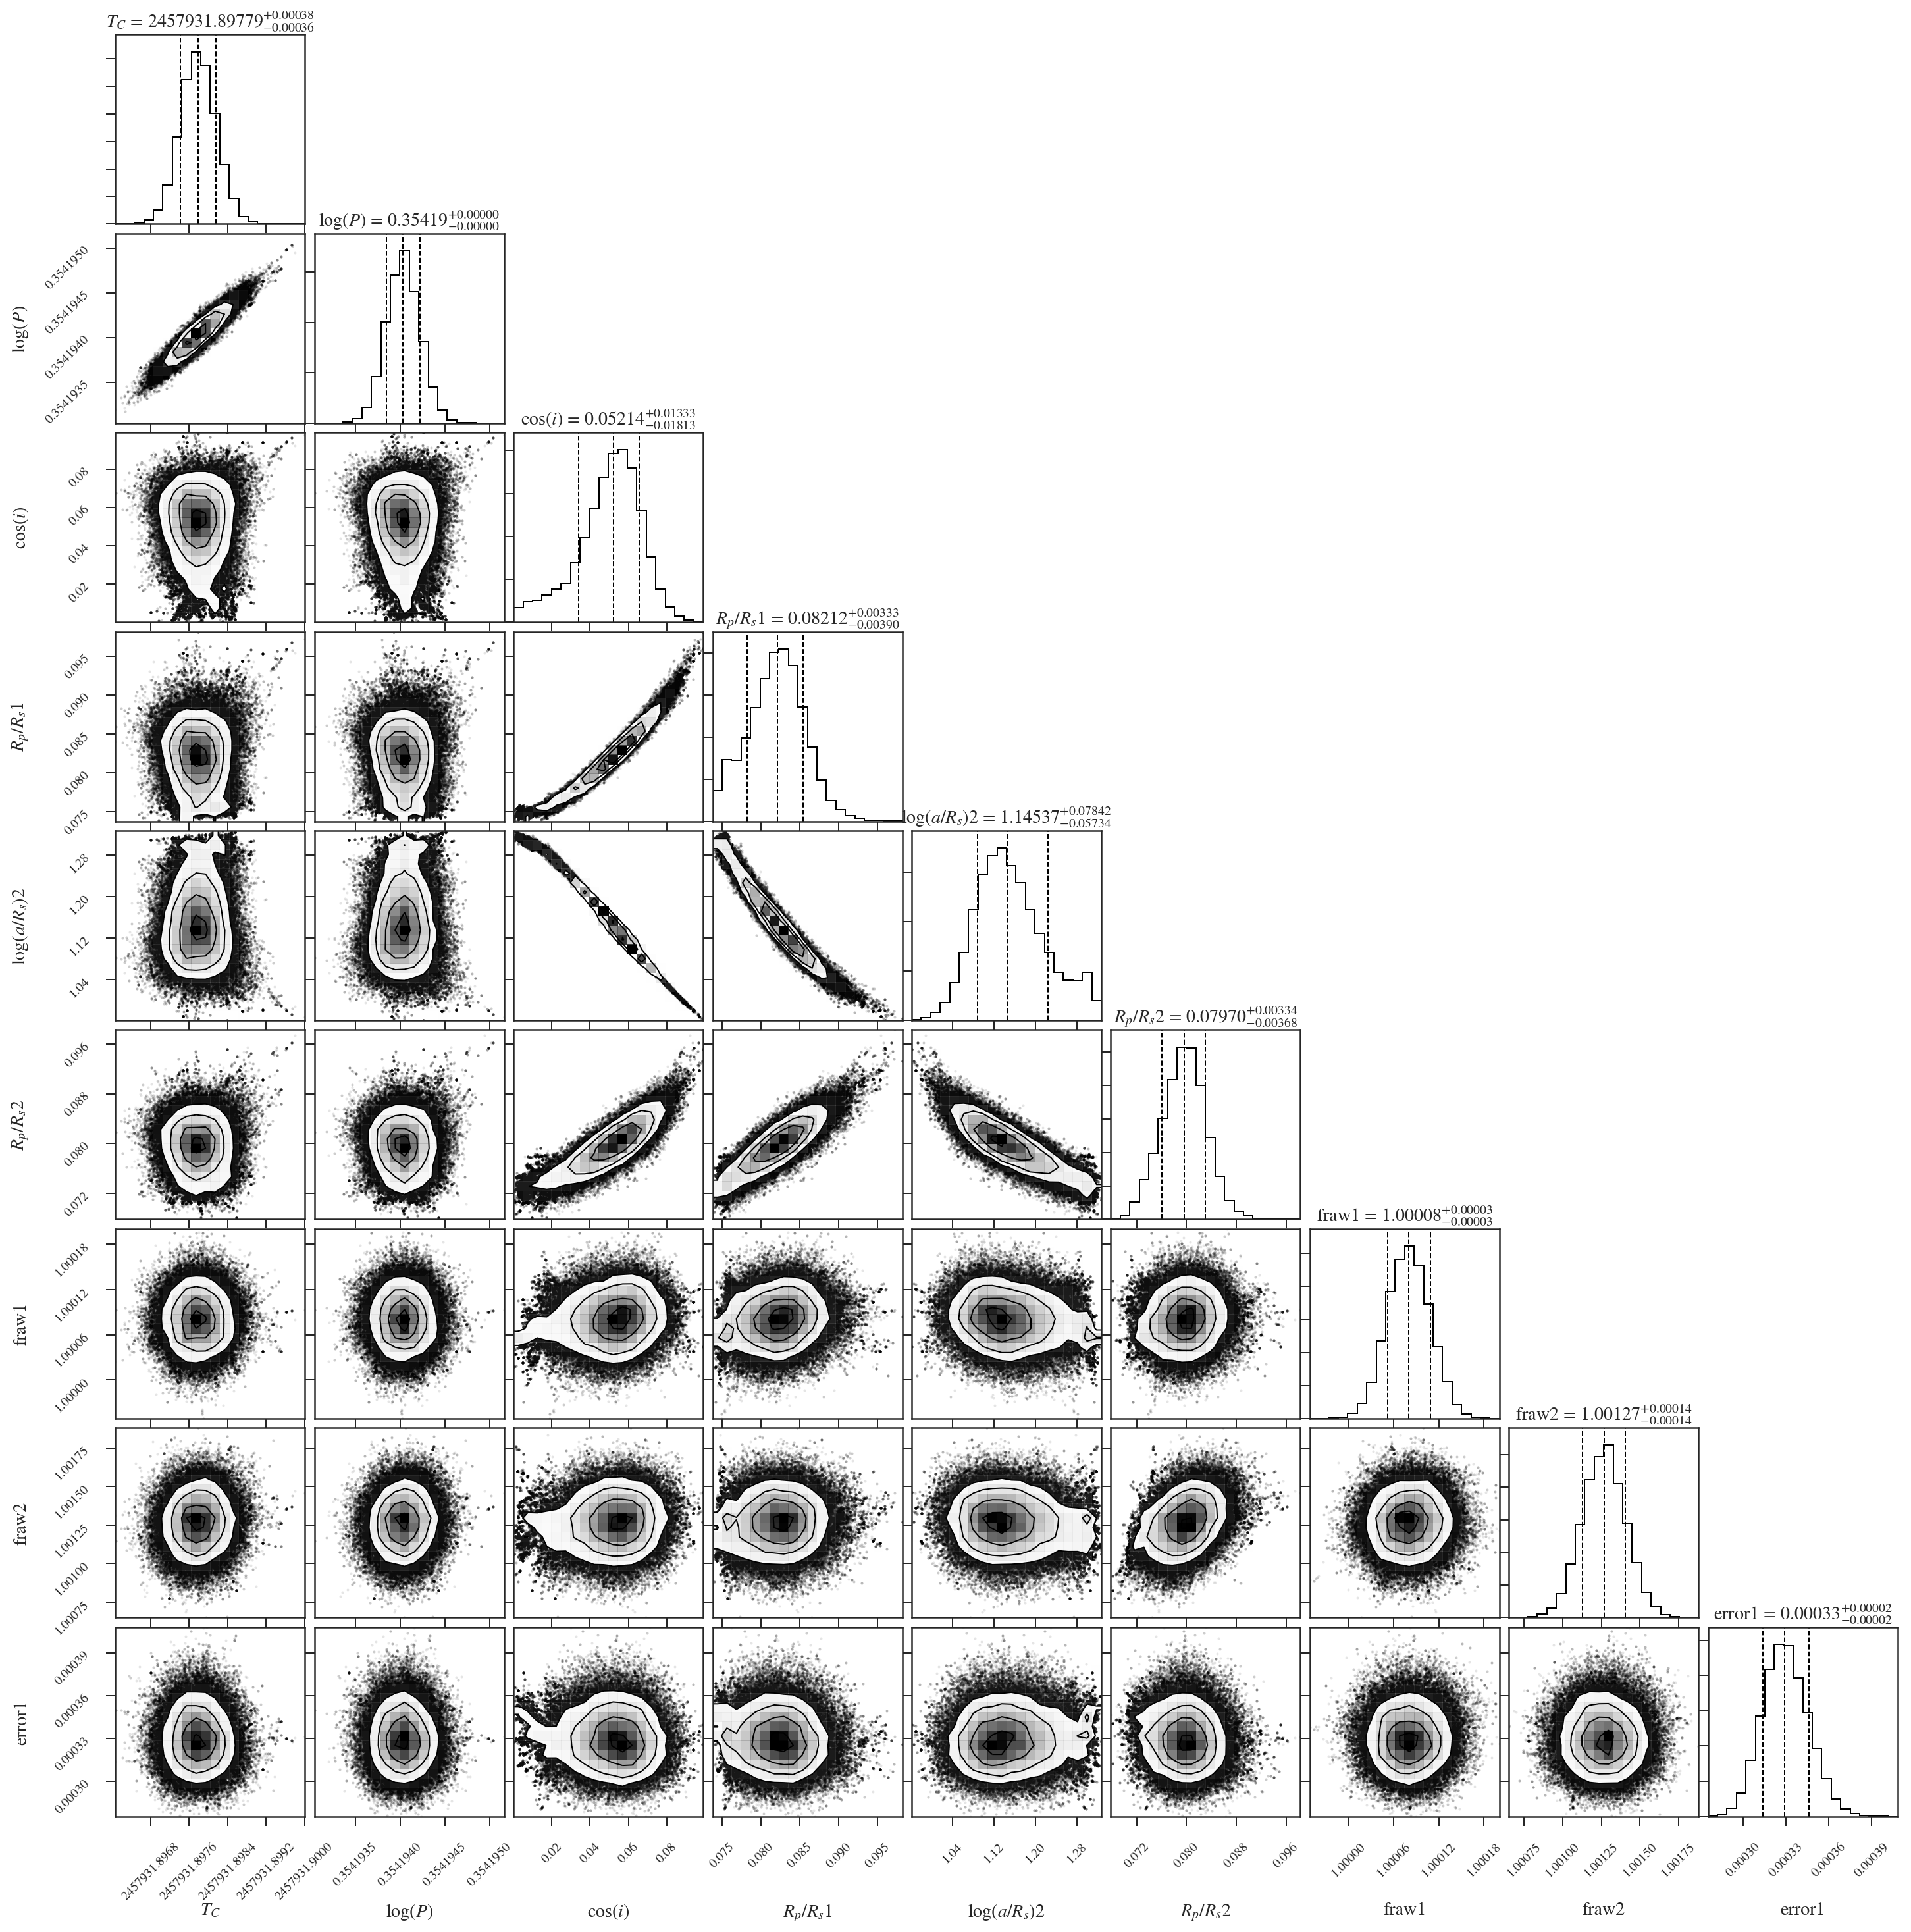

In [22]:
TF.plot_corner(burn=1000,show_titles=True)

In [23]:
TF.gelman_rubin()

array([1.01773692, 1.01582429, 1.12985304, 1.0796688 , 1.11155599,
       1.07412626, 1.00847689, 1.02118552, 1.00277193])

In [24]:
df = TF.get_df_flatchain(burn=1000)

In [25]:
df["P"] = 10.**df["logP"].values
df["i"] = np.rad2deg(np.arccos(df["cos(i)"].values))
df["aRs"] = 10.**df["log(a/Rs)"].values
# K2 parameters
df_param_k2 = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_1'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)
# Ground based parameters
df_param_ground = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_2'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3


### Ground-based parameters

In [26]:
df_param_ground

medvals         minus          plus  \
0   2.457932e+06  3.636251e-04  3.758986e-04   
1   2.260445e+00  9.681079e-07  9.860485e-07   
2   7.969866e-02  3.675699e-03  3.336943e-03   
3   2.496675e+00  2.626759e-01  2.705466e-01   
4   2.227388e-01  2.343441e-02  2.413659e-02   
5   6.351876e-03  5.723858e-04  5.430350e-04   
6   1.397544e+01  1.728474e+00  2.765892e+00   
7   1.877904e-02  2.937721e-03  4.120487e-03   
8   1.010555e+01  3.304916e+00  7.265812e+00   
9   8.701151e+01  7.650923e-01  1.039920e+00   
10  7.285790e-01  1.594173e-01  7.324258e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.251208e+02  3.721207e+01  3.053318e+01   
14  2.266821e+01  6.954237e+00  7.248132e+00   
15  4.110202e-02  1.832895e-03  1.819638e-03   
16  6.061115e-03  2.053582e-03  2.232037e-03   
17  2.457933e+06  3.639827e-04  3.762757e-04   

                                    values  \
0    $2457931.89779_{-0.00036}^{+0.00038}$   
1   $2.26044547_{-0.0000010}^{+0.0000010}$   
2             $0.0797_{-0.0037}^{+0.0033}$   
3                    $2.5_{-0.26}^{+0.27}$   
4                $0.223_{-0.023}^{+0.024}$   
5          $0.00635_{-0.00057}^{+0.00054}$   
6                     $14.0_{-1.7}^{+2.8}$   
7             $0.0188_{-0.0029}^{+0.0041}$   
8                     $10.1_{-3.3}^{+7.3}$   
9                   $87.01_{-0.77}^{+1.0}$   
10                $0.729_{-0.16}^{+0.073}$   
11                     $0.0_{-0.0}^{+0.0}$   
12                     $0.0_{-0.0}^{+0.0}$   
13                 $425.0_{-37.0}^{+31.0}$   
14                    $22.7_{-7.0}^{+7.2}$   
15            $0.0411_{-0.0018}^{+0.0018}$   
16            $0.0061_{-0.0021}^{+0.0022}$   
17   $2457933.02801_{-0.00036}^{+0.00038}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

### Parameters from K2 

In [27]:
df_param_k2

medvals         minus          plus  \
0   2.457932e+06  3.636251e-04  3.758986e-04   
1   2.260445e+00  9.681079e-07  9.860485e-07   
2   8.212265e-02  3.902512e-03  3.334153e-03   
3   2.570013e+00  2.676848e-01  2.785378e-01   
4   2.292816e-01  2.388128e-02  2.484952e-02   
5   6.744129e-03  6.257396e-04  5.587355e-04   
6   1.397544e+01  1.728474e+00  2.765892e+00   
7   1.878615e-02  2.957788e-03  4.113490e-03   
8   1.010555e+01  3.304916e+00  7.265812e+00   
9   8.701151e+01  7.650923e-01  1.039920e+00   
10  7.285790e-01  1.594173e-01  7.324258e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.251053e+02  3.719661e+01  3.055406e+01   
14  2.266490e+01  6.950935e+00  7.252850e+00   
15  4.126861e-02  1.902713e-03  1.901409e-03   
16  6.244223e-03  2.137999e-03  2.346749e-03   
17  2.457933e+06  3.639827e-04  3.762757e-04   

                                    values  \
0    $2457931.89779_{-0.00036}^{+0.00038}$   
1   $2.26044547_{-0.0000010}^{+0.0000010}$   
2             $0.0821_{-0.0039}^{+0.0033}$   
3                   $2.57_{-0.27}^{+0.28}$   
4                $0.229_{-0.024}^{+0.025}$   
5          $0.00674_{-0.00063}^{+0.00056}$   
6                     $14.0_{-1.7}^{+2.8}$   
7             $0.0188_{-0.0030}^{+0.0041}$   
8                     $10.1_{-3.3}^{+7.3}$   
9                   $87.01_{-0.77}^{+1.0}$   
10                $0.729_{-0.16}^{+0.073}$   
11                     $0.0_{-0.0}^{+0.0}$   
12                     $0.0_{-0.0}^{+0.0}$   
13                 $425.0_{-37.0}^{+31.0}$   
14                    $22.7_{-7.0}^{+7.3}$   
15            $0.0413_{-0.0019}^{+0.0019}$   
16            $0.0062_{-0.0021}^{+0.0023}$   
17   $2457933.02801_{-0.00036}^{+0.00038}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

In [28]:
df_k2_28b_jointground_final=pd.DataFrame({'Labels': df_param_ground['Labels'],'Description':df_param_ground['Description'],'Ground': df_param_ground['values']})
#df_k2_28b_final
df_k2_28b_jointground_final.to_csv('../data/k2_28b/k2-28b_jointground_for_latex_table.csv')

In [29]:
df_k2_28b_jointk2_final=pd.DataFrame({'Labels': df_param_k2['Labels'],'Description':df_param_k2['Description'],'K2': df_param_k2['values']})
#df_k2_28b_final
df_k2_28b_jointk2_final.to_csv('../data/k2_28b/k2-28b_jointk2_for_latex_table.csv')

# Plot with MCMC joint parameters

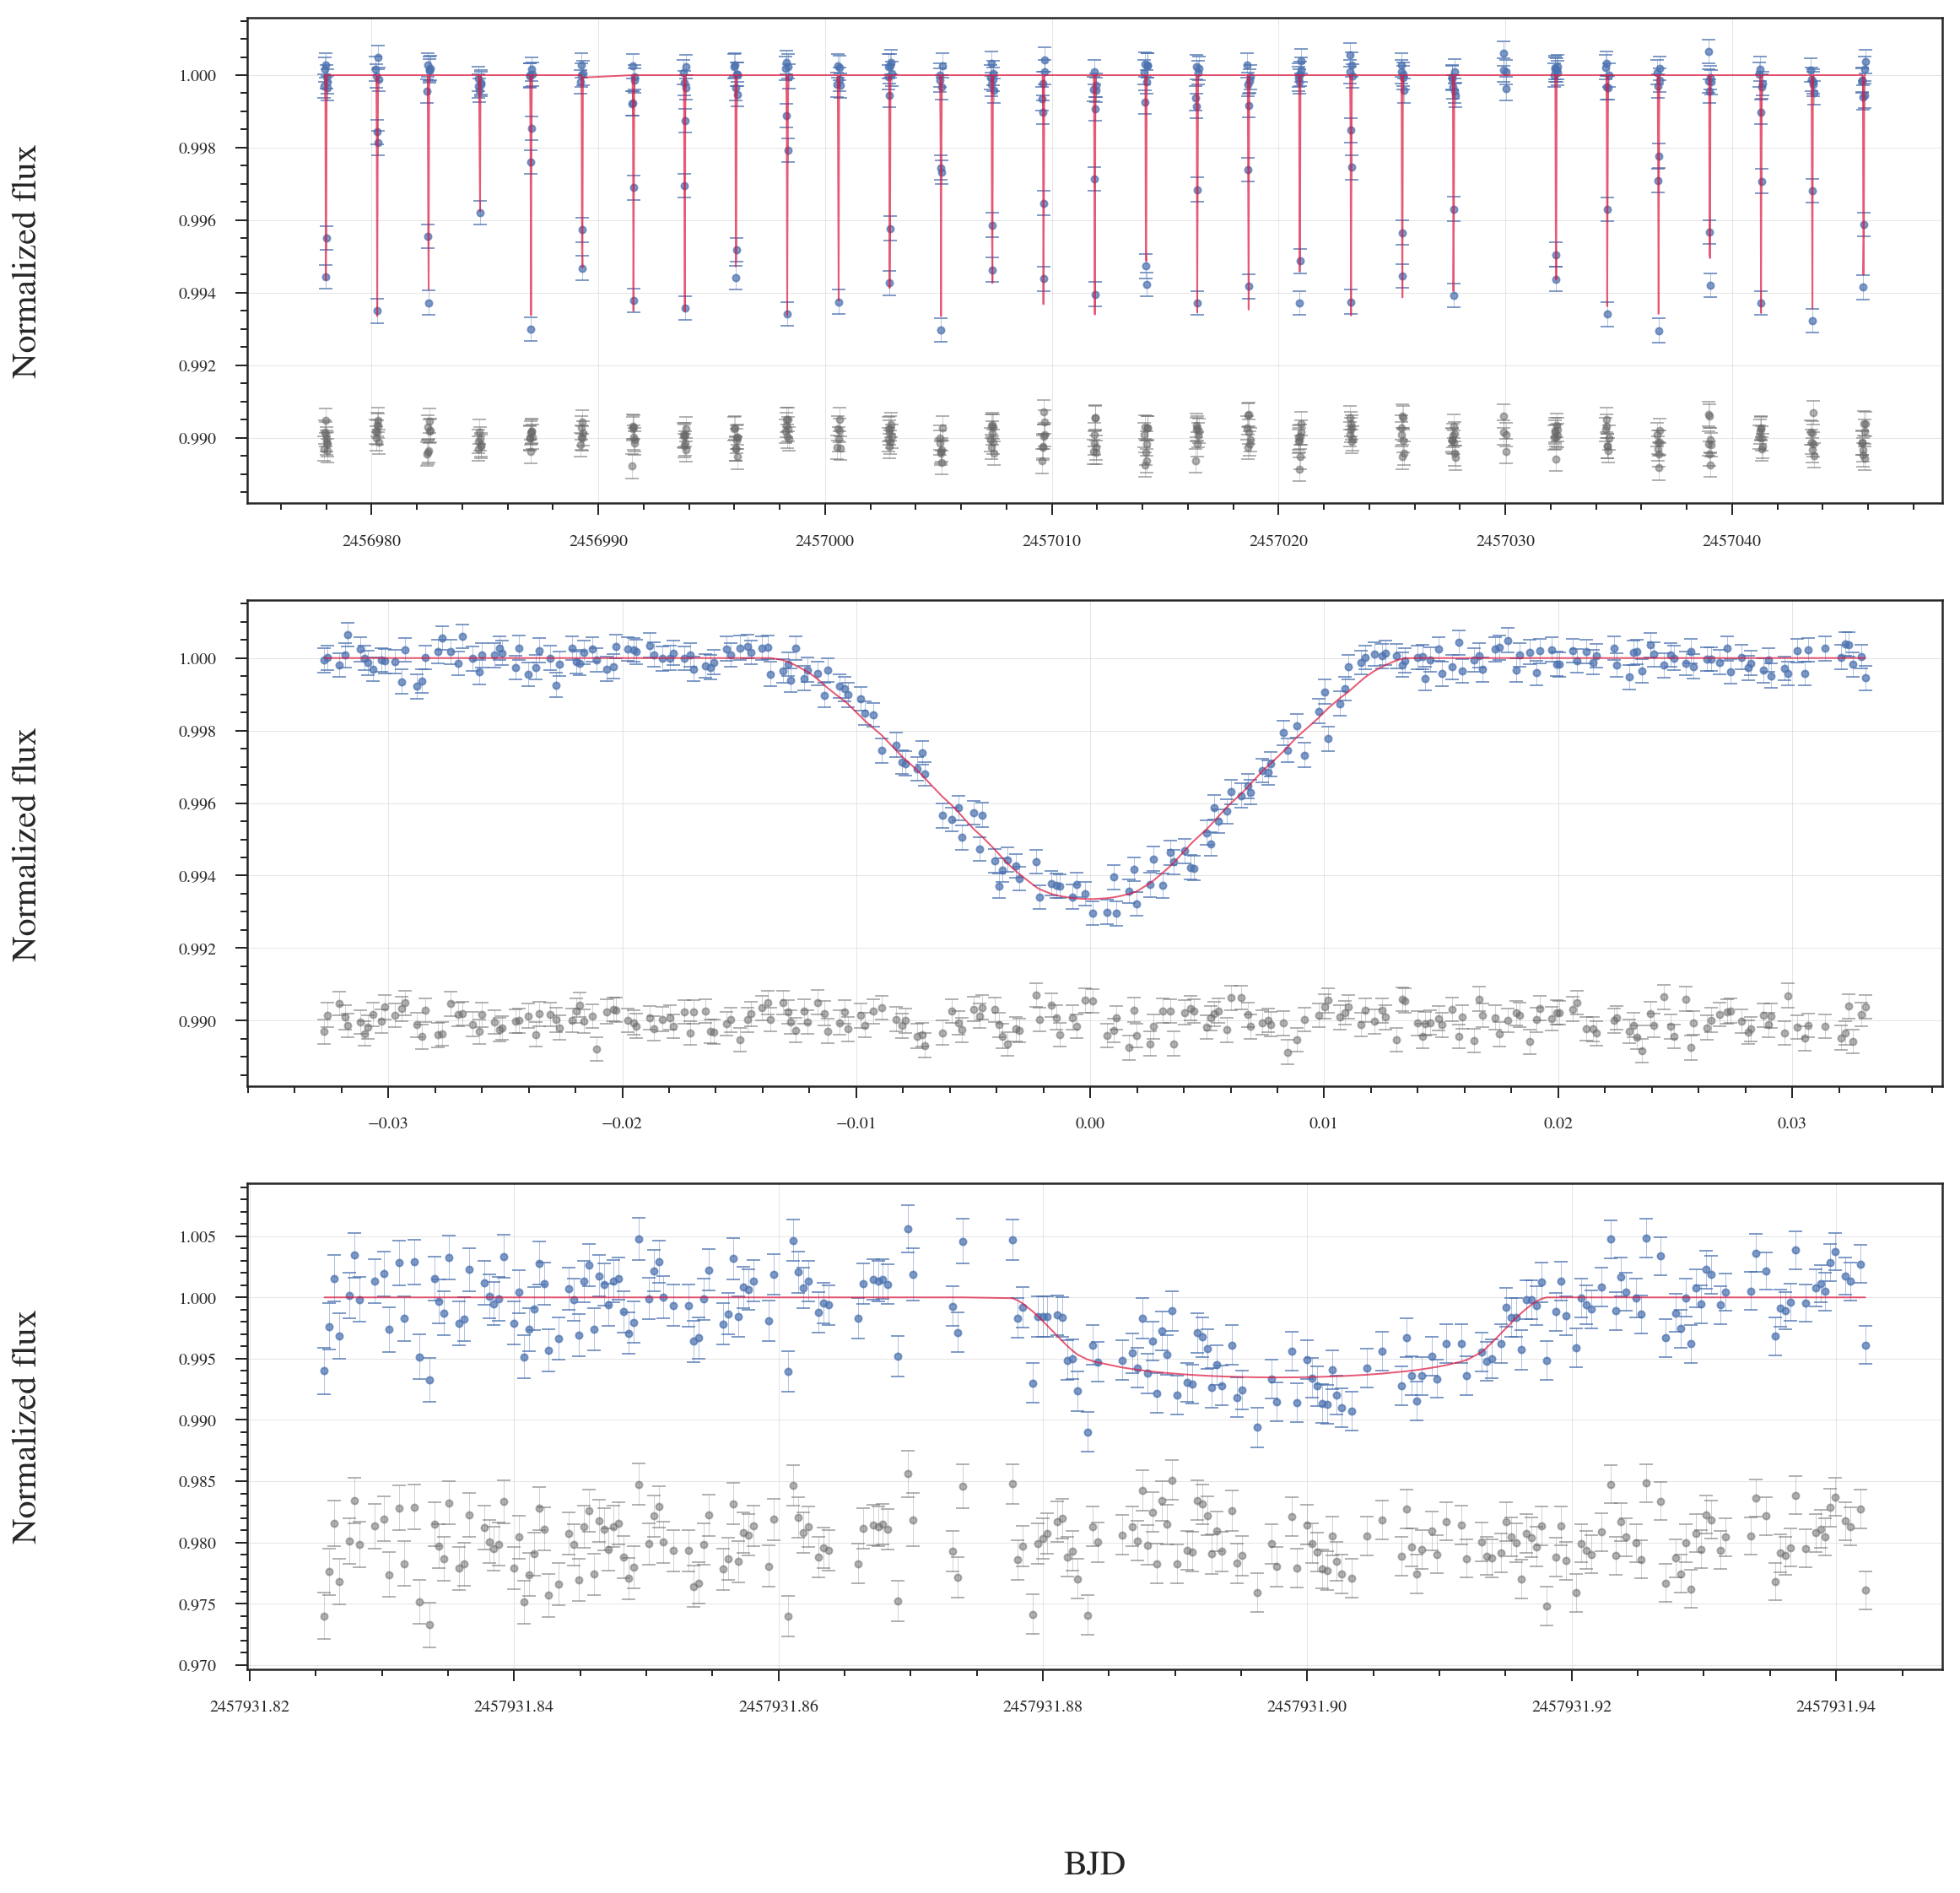

In [34]:
pv = TF.get_mean_values_mcmc_posteriors().medvals.values
t0  = TF.get_mean_values_mcmc_posteriors().medvals.values[0]
p  = 10.**TF.get_mean_values_mcmc_posteriors().medvals.values[1]
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,18))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

In [35]:
d = {'phase_fold_time_k2': df_fold.phase, 'phase_fold_scaled_flux_k2': df_fold.scaled_flux, 'scaled_error_k2':scaled_error1,
    'yresidual_k2': residual1, 'xmodel_k2':df_fold.phase, 'ymodel_k2':df_fold.model }
k2_data_for_plotting=pd.DataFrame(data=d)
k2_data_for_plotting.to_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_k2.csv")

In [ ]:
d = {'time_ground': TF.lpf.data2["time"], 'scaled_flux_ground': scaled_flux2, 'scaled_error_ground':scaled_error2,
    'yresidual_ground': residual2, 'xmodel_ground': TF.lpf.data2["time"], 'ymodel_ground':model_trend2}
ground_data_for_plotting=pd.DataFrame(data=d)
ground_data_for_plotting.to_csv("../data/k2_100b/K2_data_k2_28b_for_plotting_ground.csv")